In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('..')

import torch

from rl4co.models.zoo import AttentionModel, AttentionModelPolicy
from rl4co.utils.trainer import RL4COTrainer

from envs import SHPPEnv, SHPPGenerator
from models.env_embeddings.shpp import SHPPContext, SHPPDynamicEmbedding, SHPPInitEmbedding

/home/cbhua/miniconda/envs/divroute/lib/python3.11/site-packages/torchrl/data/replay_buffers/samplers.py:36: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. If you installed TorchRL from PyPI, please report the bug on TorchRL github. If you installed TorchRL locally and/or in development mode, check that you have all the required compiling packages.
  warnings.warn(EXTENSION_WARNING)
/home/cbhua/miniconda/envs/divroute/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
generator = SHPPGenerator(num_loc=20)
env = SHPPEnv(generator) 

embed_dim = 128
context_embedding = SHPPContext(embed_dim)
init_embedding = SHPPInitEmbedding(embed_dim)
static_embedding = SHPPDynamicEmbedding(embed_dim)

policy = AttentionModelPolicy(
    embed_dim=embed_dim,
    init_embedding=init_embedding,
    context_embedding=context_embedding,
    dynamic_embedding=static_embedding,
    env_name=env.name,
)

model = AttentionModel(
    env, 
    policy,
    baseline="rollout",
    train_data_size=100_000,
    val_data_size=10_000,
    optimizer_kwargs={"lr": 1e-4},
) 

/home/cbhua/miniconda/envs/divroute/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/cbhua/miniconda/envs/divroute/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


Problem 1 | Cost: 9.004
Problem 2 | Cost: 11.666
Problem 3 | Cost: 9.553


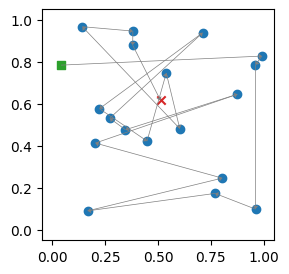

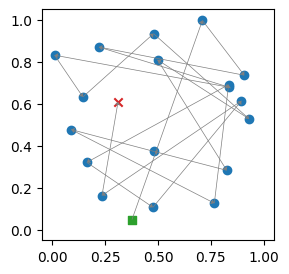

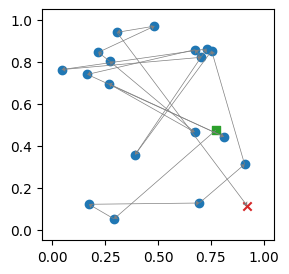

In [3]:
# Greedy rollouts over untrained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['reward'].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

In [4]:
trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="gpu",
    devices=1,
    logger=None,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cbhua/miniconda/envs/divroute/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [5]:
trainer.fit(model)

Missing logger folder: /home/cbhua/github/divroute/examples/lightning_logs
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | SHPPEnv              | 0     
1 | policy   | AttentionModelPolicy | 726 K 
2 | baseline | WarmupBaseline       | 726 K 
--------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.813     Total estimated model params size (MB)


/home/cbhua/miniconda/envs/divroute/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/cbhua/miniconda/envs/divroute/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 2: 100%|██████████| 196/196 [00:04<00:00, 39.81it/s, v_num=0, train/reward=-4.70, train/loss=-.847, val/reward=-4.60] 

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 196/196 [00:05<00:00, 34.95it/s, v_num=0, train/reward=-4.70, train/loss=-.847, val/reward=-4.60]


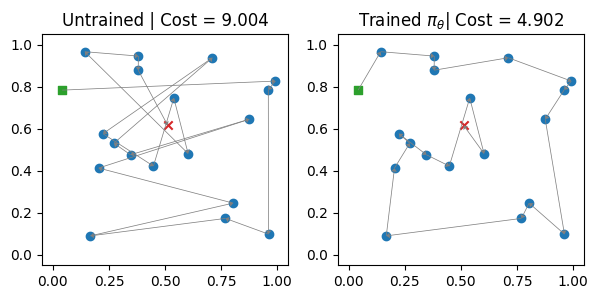

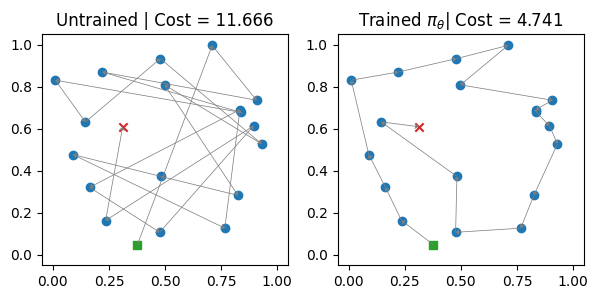

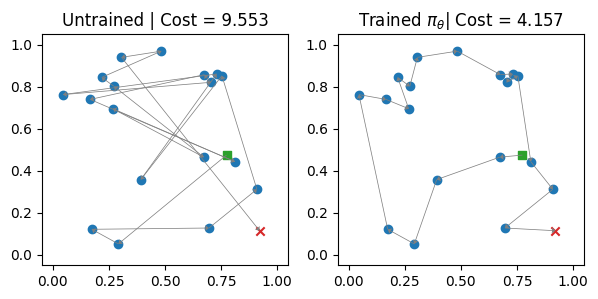

In [6]:
# Greedy rollouts over trained model (same states as previous plot)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(7, 3))
    env.render(td, actions_untrained[i], ax=axs[0]) 
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

### Train and Save multiple SHPP models


In [8]:
# Save the shpp checkpoint
num_loc_list = [10, 20, 30, 40, 50]

for num_loc in num_loc_list:
    generator = SHPPGenerator(num_loc=num_loc)
    env = SHPPEnv(generator) 

    embed_dim = 128
    context_embedding = SHPPContext(embed_dim)
    init_embedding = SHPPInitEmbedding(embed_dim)
    static_embedding = SHPPDynamicEmbedding(embed_dim)

    policy = AttentionModelPolicy(
        embed_dim=embed_dim,
        init_embedding=init_embedding,
        context_embedding=context_embedding,
        dynamic_embedding=static_embedding,
        env_name=env.name,
    )

    model = AttentionModel(
        env, 
        policy,
        baseline="rollout",
        train_data_size=100_000,
        val_data_size=10_000,
        optimizer_kwargs={"lr": 1e-4},
    ) 

    trainer = RL4COTrainer(
        max_epochs=10,
        accelerator="gpu",
        devices=1,
        logger=None,
    )

    trainer.fit(model)

    trainer.save_checkpoint(f"../checkpoints/shpp/{num_loc}.ckpt")

/home/cbhua/miniconda/envs/divroute/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/cbhua/miniconda/envs/divroute/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type                 | Params
--------------------------------------------------
0 

/home/cbhua/miniconda/envs/divroute/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/cbhua/miniconda/envs/divroute/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 196/196 [00:03<00:00, 64.45it/s, v_num=2, train/reward=-3.15, train/loss=-.0327, val/reward=-3.16]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 196/196 [00:03<00:00, 57.19it/s, v_num=2, train/reward=-3.15, train/loss=-.0327, val/reward=-3.16]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | SHPPEnv              | 0     
1 | policy   | AttentionModelPolicy | 726 K 
2 | baseline | WarmupBaseline       | 726 K 
--------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.813     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 196/196 [00:05<00:00, 38.49it/s, v_num=3, train/reward=-4.59, train/loss=-.474, val/reward=-4.54]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 196/196 [00:05<00:00, 33.94it/s, v_num=3, train/reward=-4.59, train/loss=-.474, val/reward=-4.54]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
val_file not set. Generating dataset instead


test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | SHPPEnv              | 0     
1 | policy   | AttentionModelPolicy | 726 K 
2 | baseline | WarmupBaseline       | 726 K 
--------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.813     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 196/196 [00:07<00:00, 27.68it/s, v_num=4, train/reward=-5.56, train/loss=-.711, val/reward=-5.45]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 196/196 [00:08<00:00, 24.21it/s, v_num=4, train/reward=-5.56, train/loss=-.711, val/reward=-5.45]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
val_file not set. Generating dataset instead


test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | SHPPEnv              | 0     
1 | policy   | AttentionModelPolicy | 726 K 
2 | baseline | WarmupBaseline       | 726 K 
--------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.813     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 196/196 [00:09<00:00, 19.98it/s, v_num=5, train/reward=-6.48, train/loss=-2.16, val/reward=-6.35] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 196/196 [00:10<00:00, 18.60it/s, v_num=5, train/reward=-6.48, train/loss=-2.16, val/reward=-6.35]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | SHPPEnv              | 0     
1 | policy   | AttentionModelPolicy | 726 K 
2 | baseline | WarmupBaseline       | 726 K 
--------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.813     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 196/196 [00:12<00:00, 16.12it/s, v_num=6, train/reward=-7.28, train/loss=-3.10, val/reward=-7.08]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 196/196 [00:14<00:00, 14.00it/s, v_num=6, train/reward=-7.28, train/loss=-3.10, val/reward=-7.08]
